In [1]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

We are using ResNet50 to extract the features and do KNN on these features

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

In [8]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [9]:
#feature extraction
#shallow copy the model except prediction layer
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
feat_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# !"content/lfw.tgz" -d "/content/lfw"
!tar -xvf  "/content/lfw.tgz" -C "/content/lfw"
# !tar -xvf /content/x.tar.gz

In [7]:
import shutil

shutil.rmtree('/content/lfw')

In [6]:
from tqdm import tqdm

In [ ]:
root_dir = '/content/lfw/lfw'
image_extensions = ['.jpg'] 
dic={}
# def ListFile(root_dir):
images = []
counter = 1
for root, dirs, filenames in os.walk(root_dir):
    for filename in tqdm(filenames):
        if any(ext in filename for ext in image_extensions):
            dic[counter]=filename
            images.append(os.path.join(root, filename))
            counter += 1
# return sorted(file_lists)
# print(dic[0:20])

Resize the images to expected dimensions for ResNet50(224x224)

In [31]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [32]:
image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]

Extract feature of every image using ResNet50

In [ ]:
features = []
for i,img_path in enumerate(image_paths):
    img, x = load_image(img_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)
print(len(features))


Too many features cause uncessary noises. Use PCA to choose 900 principle features and ignore the rest.

In [34]:
from sklearn.decomposition import PCA
features = np.array(features)
pca = PCA(n_components=900)
pca.fit(features)

PCA(n_components=900)

In [35]:
pca_features = pca.transform(features)

Randomly choose an image

5176
Damon_Stoudamire_0001.jpg


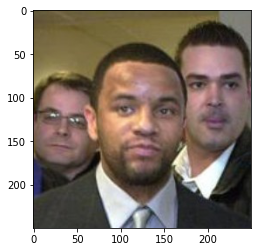

In [44]:
import random
import matplotlib.pyplot as plt
# grab a random query image
query_image_idx = int(len(image_paths) * random.random())
print(query_image_idx)
# let's display the image
# img = image.load_img(image_paths[query_image_idx])
img = image.load_img(images[query_image_idx])
print(dic[query_image_idx+1])
plt.imshow(img)

In [45]:
#compute the relative distance between the PCA feature vectors of the selected image 
#and the PCA feature vectors of other images (including itself)
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]


5176
Image 1 


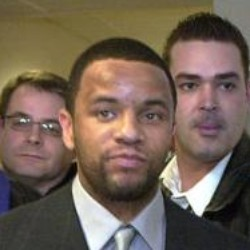

Similarity:  1.0
11545
Image 2 


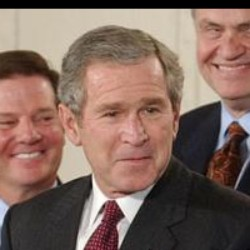

Similarity:  0.6590120792388916
1715
Image 3 


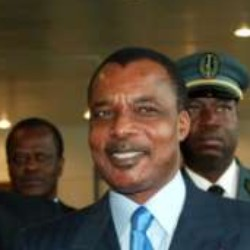

Similarity:  0.6329644918441772
9596
Image 4 


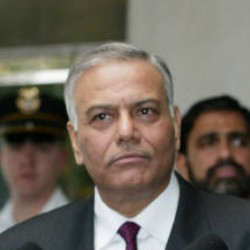

Similarity:  0.6175901293754578
11548
Image 5 


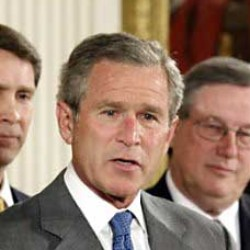

Similarity:  0.6174941658973694
9499
Image 6 


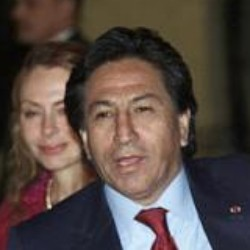

Similarity:  0.6004548668861389
1698
Image 7 


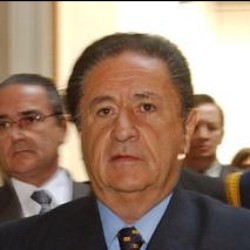

Similarity:  0.5984693169593811
10662
Image 8 


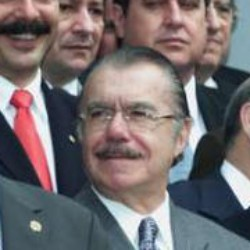

Similarity:  0.5947885513305664
11729
Image 9 


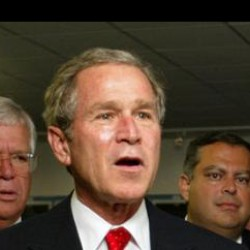

Similarity:  0.5882778763771057
3693
Image 10 


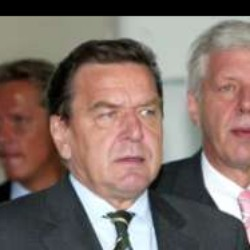

Similarity:  0.58138108253479
1921
Image 11 


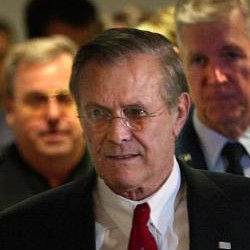

Similarity:  0.5714109539985657
3462
Image 12 


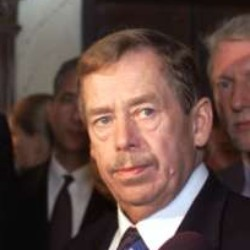

Similarity:  0.5711385011672974
11969
Image 13 


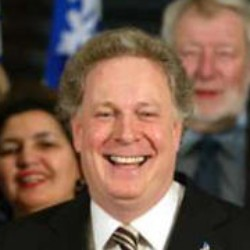

Similarity:  0.5697201490402222
12637
Image 14 


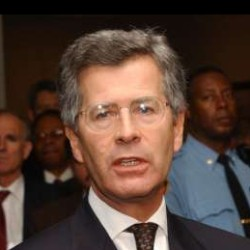

Similarity:  0.5614782571792603
5161
Image 15 


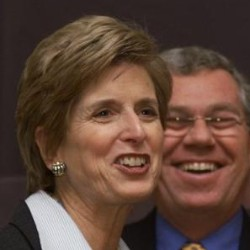

Similarity:  0.5608935356140137
10868
Image 16 


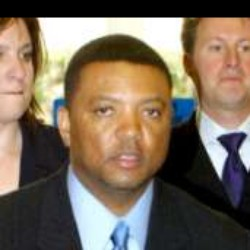

Similarity:  0.5605834126472473
7301
Image 17 


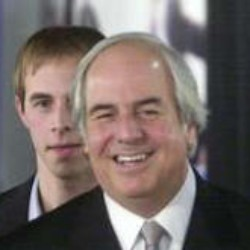

Similarity:  0.5580931901931763
1713
Image 18 


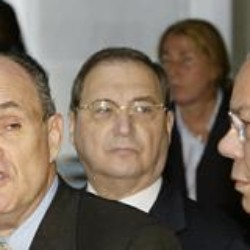

Similarity:  0.5580742955207825
9012
Image 19 


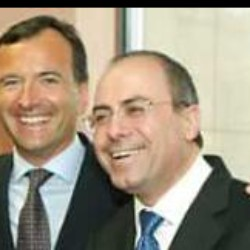

Similarity:  0.5559130311012268
4724
Image 20 


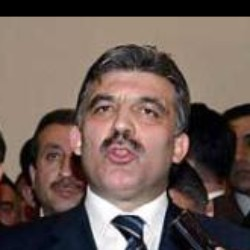

Similarity:  0.5497260093688965


In [46]:
#sort the similar_idx which contains the image's similarity to evey image(including itself), choose the most similar 20 items.
from IPython.core.display import Image
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[0:20]

test_similar=sorted(similar_idx)[0:20]
for i,idx in enumerate(idx_closest):  
    print(idx)
    # print(similar_idx[idx])
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Concatnate the images

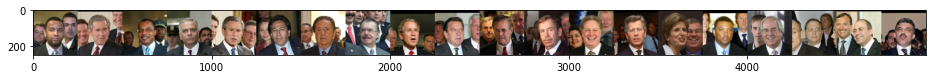

In [47]:
thumbs = []
for idx in idx_closest:
    img = image.load_img(image_paths[idx])
    thumbs.append(img)
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [ ]:
#clearer display of baseline(part I)

In [48]:
#Combine the codes above into a function, generate a random image index and its corresponding 20 most similar images
#(store as index in image_paths)
def ret(image_paths):
  query_image_idx = int(len(image_paths) * random.random())
  img = image.load_img(image_paths[query_image_idx])
  similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
  idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[0:20]
  test_similar=sorted(similar_idx)[0:20]
  thumbs = []
  for idx in idx_closest:
      img = image.load_img(image_paths[idx])
      thumbs.append(img)
  return query_image_idx,thumbs,idx_closest,test_similar

Below are 10 randomly generated query images and their 20 most similar outputs.
This is our baseline production. We implicily use the KNN algoritm as we are choosing k items which are most closest (in terms of cosine distance of PCA feature vectors) to the query image.

QUERY1

Query Image 1


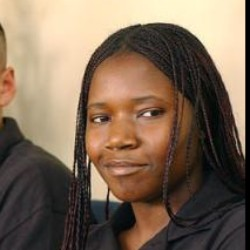



Image 1 


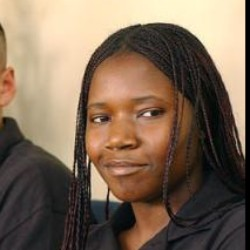

Similarity:  1.0
Image 2 


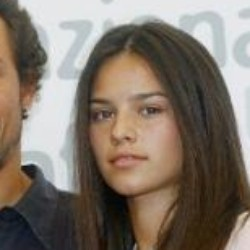

Similarity:  0.5373786687850952
Image 3 


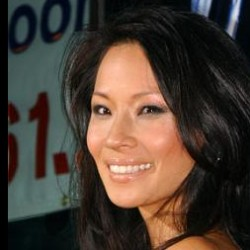

Similarity:  0.5284623503684998
Image 4 


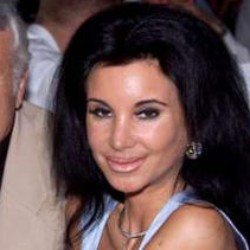

Similarity:  0.5278000831604004
Image 5 


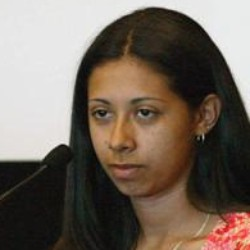

Similarity:  0.5216939449310303
Image 6 


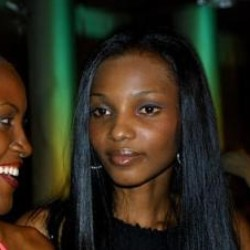

Similarity:  0.5052673816680908
Image 7 


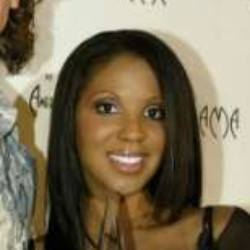

Similarity:  0.5050094723701477
Image 8 


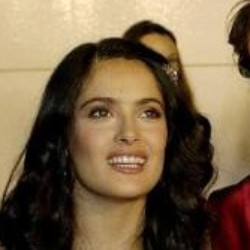

Similarity:  0.4983135461807251
Image 9 


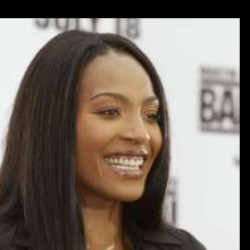

Similarity:  0.49532264471054077
Image 10 


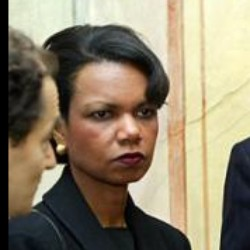

Similarity:  0.49276721477508545
Image 11 


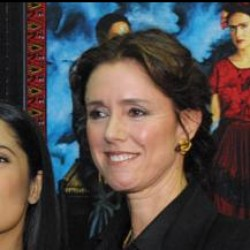

Similarity:  0.4881439507007599
Image 12 


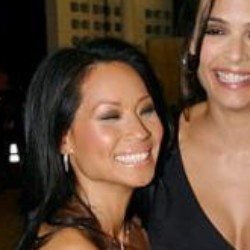

Similarity:  0.48711708188056946
Image 13 


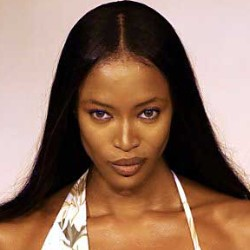

Similarity:  0.4839112162590027
Image 14 


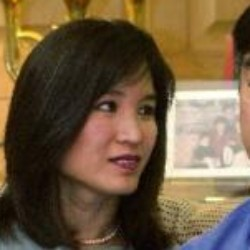

Similarity:  0.4837907552719116
Image 15 


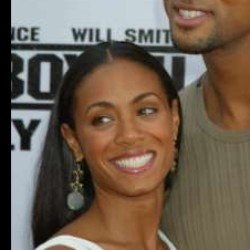

Similarity:  0.48123082518577576
Image 16 


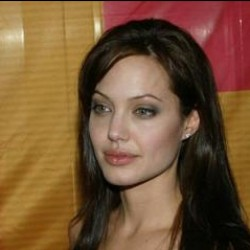

Similarity:  0.4803244173526764
Image 17 


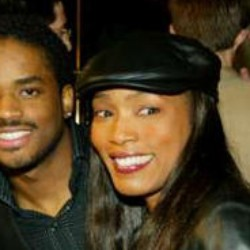

Similarity:  0.47916659712791443
Image 18 


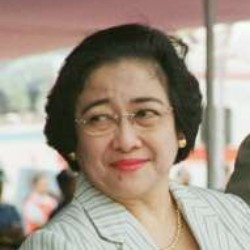

Similarity:  0.47814640402793884
Image 19 


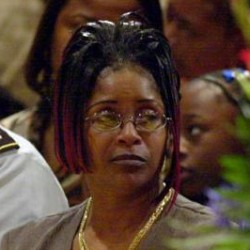

Similarity:  0.4768639802932739
Image 20 


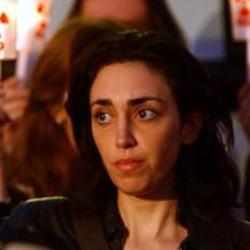

Similarity:  0.4671061336994171


In [49]:
from IPython.core.display import Image
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 1")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Query 2

Query Image 2


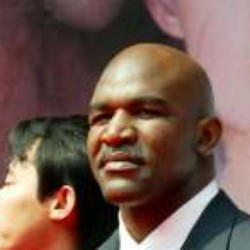



Image 1 


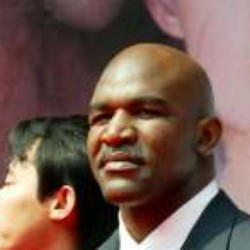

Similarity:  1.0
Image 2 


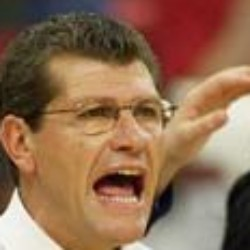

Similarity:  0.43326711654663086
Image 3 


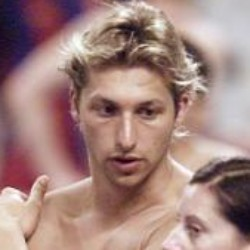

Similarity:  0.4220963716506958
Image 4 


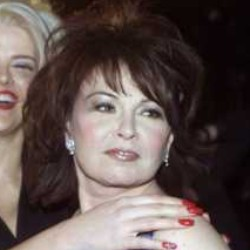

Similarity:  0.39728549122810364
Image 5 


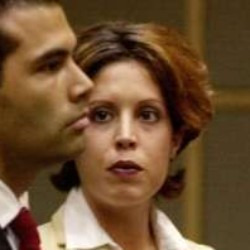

Similarity:  0.38119539618492126
Image 6 


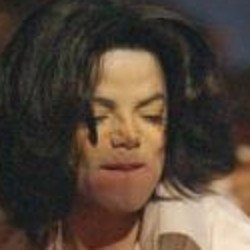

Similarity:  0.3760685324668884
Image 7 


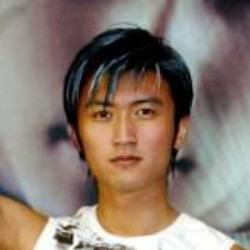

Similarity:  0.37550753355026245
Image 8 


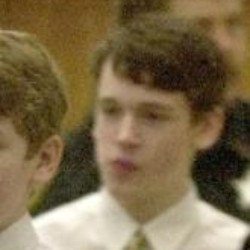

Similarity:  0.37433549761772156
Image 9 


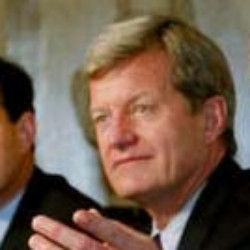

Similarity:  0.37211063504219055
Image 10 


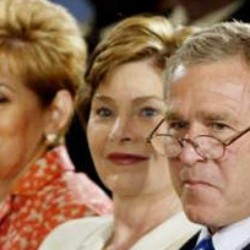

Similarity:  0.3700307607650757
Image 11 


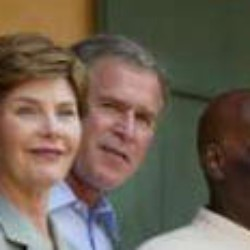

Similarity:  0.3687981069087982
Image 12 


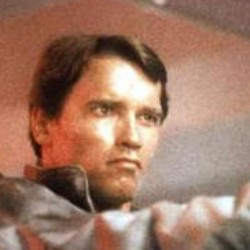

Similarity:  0.36455610394477844
Image 13 


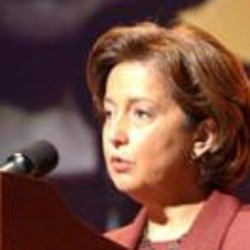

Similarity:  0.36290353536605835
Image 14 


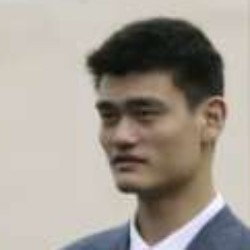

Similarity:  0.36217162013053894
Image 15 


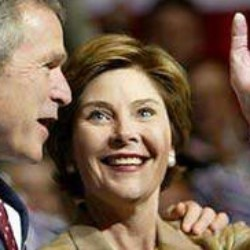

Similarity:  0.35847917199134827
Image 16 


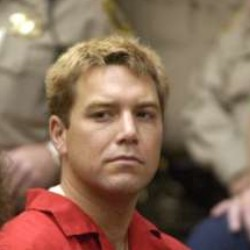

Similarity:  0.35672998428344727
Image 17 


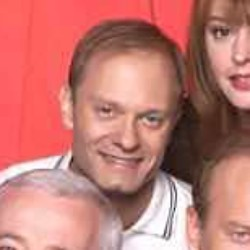

Similarity:  0.35593754053115845
Image 18 


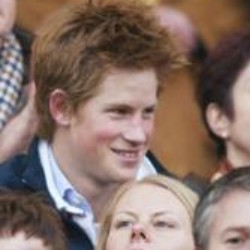

Similarity:  0.3554794490337372
Image 19 


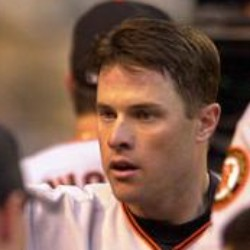

Similarity:  0.3537195324897766
Image 20 


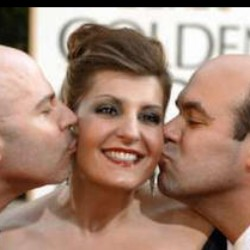

Similarity:  0.3469313979148865


In [53]:
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 2")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Query 3

Query Image 3


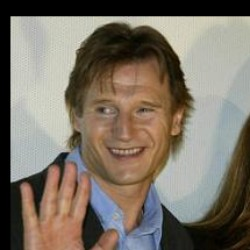



Image 1 


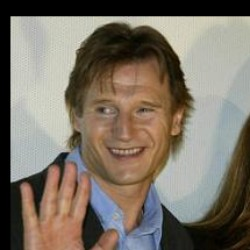

Similarity:  1.0
Image 2 


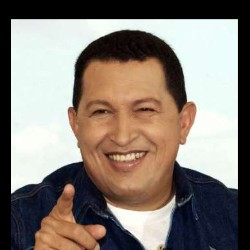

Similarity:  0.520751953125
Image 3 


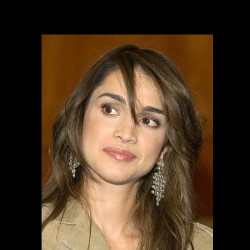

Similarity:  0.5107890367507935
Image 4 


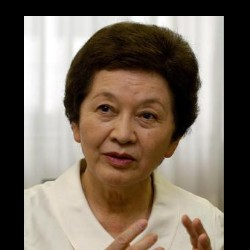

Similarity:  0.5052903890609741
Image 5 


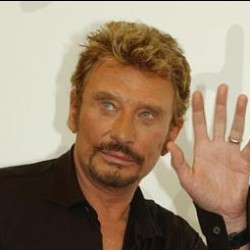

Similarity:  0.502472460269928
Image 6 


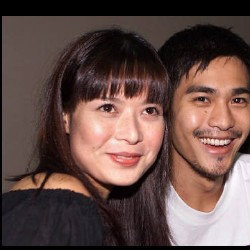

Similarity:  0.5024213194847107
Image 7 


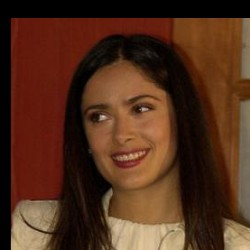

Similarity:  0.5003946423530579
Image 8 


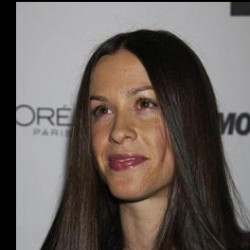

Similarity:  0.49736645817756653
Image 9 


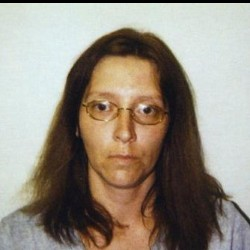

Similarity:  0.49341127276420593
Image 10 


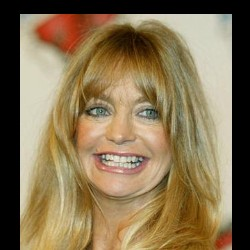

Similarity:  0.48945796489715576
Image 11 


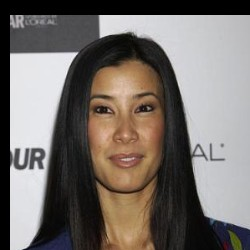

Similarity:  0.48731788992881775
Image 12 


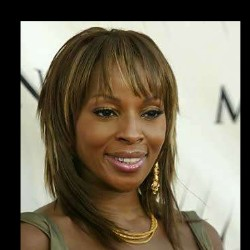

Similarity:  0.47919386625289917
Image 13 


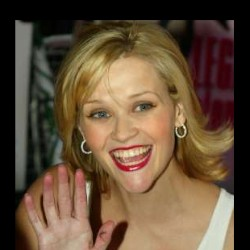

Similarity:  0.47862309217453003
Image 14 


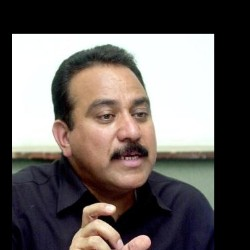

Similarity:  0.476770281791687
Image 15 


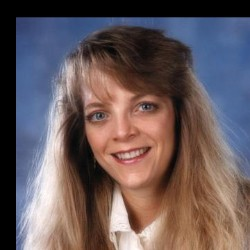

Similarity:  0.4744660258293152
Image 16 


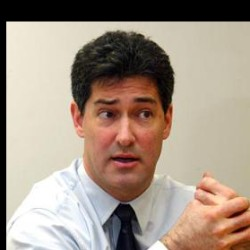

Similarity:  0.4724234938621521
Image 17 


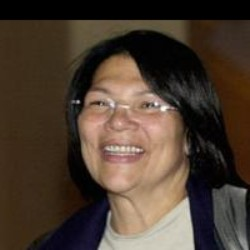

Similarity:  0.4700309932231903
Image 18 


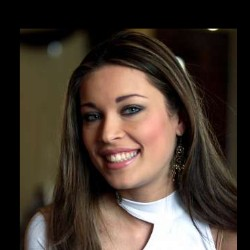

Similarity:  0.46763575077056885
Image 19 


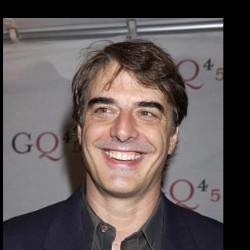

Similarity:  0.46701380610466003
Image 20 


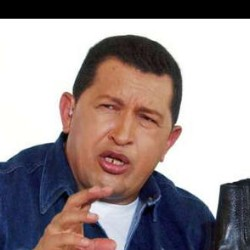

Similarity:  0.4669460356235504


In [54]:
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 3")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Query 4

Query Image 4


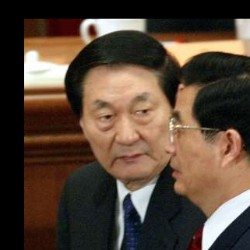



Image 1 


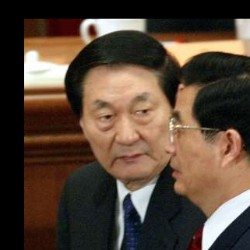

Similarity:  1.0
Image 2 


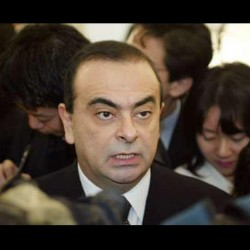

Similarity:  0.7055452466011047
Image 3 


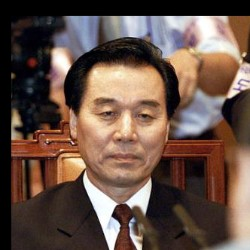

Similarity:  0.650648832321167
Image 4 


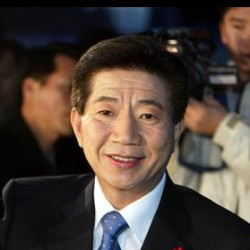

Similarity:  0.6221557259559631
Image 5 


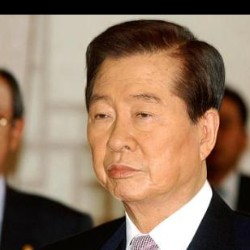

Similarity:  0.6184272766113281
Image 6 


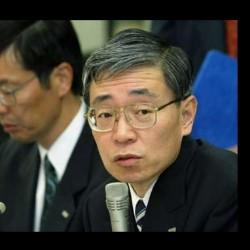

Similarity:  0.6159448623657227
Image 7 


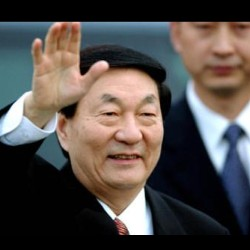

Similarity:  0.615330159664154
Image 8 


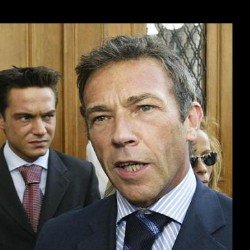

Similarity:  0.6141179800033569
Image 9 


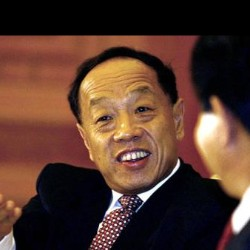

Similarity:  0.6128917336463928
Image 10 


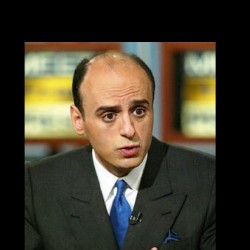

Similarity:  0.6026529669761658
Image 11 


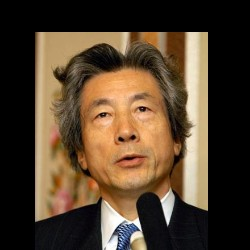

Similarity:  0.5992758274078369
Image 12 


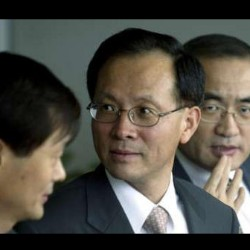

Similarity:  0.5990960001945496
Image 13 


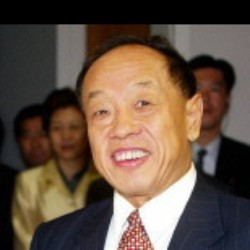

Similarity:  0.5889952182769775
Image 14 


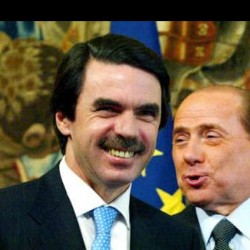

Similarity:  0.588750958442688
Image 15 


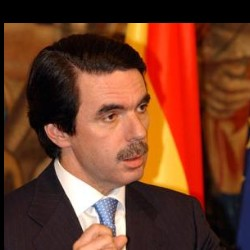

Similarity:  0.5877562165260315
Image 16 


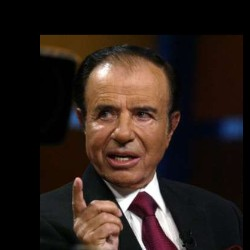

Similarity:  0.5871254801750183
Image 17 


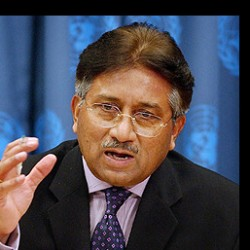

Similarity:  0.5858071446418762
Image 18 


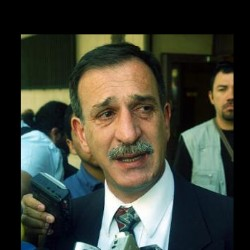

Similarity:  0.5843802690505981
Image 19 


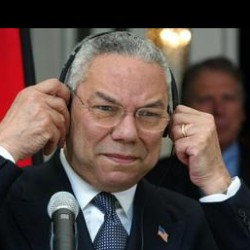

Similarity:  0.5790452361106873
Image 20 


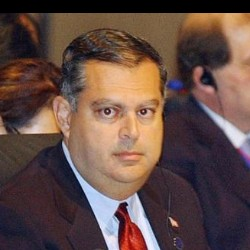

Similarity:  0.5774232745170593


In [55]:
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 4")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Query 5

Query Image 1


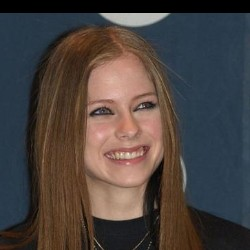



Image 1 


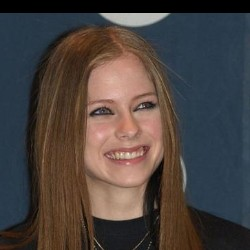

Similarity:  1.0
Image 2 


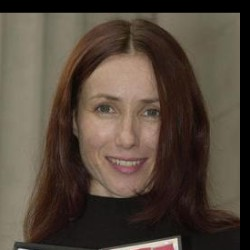

Similarity:  0.6952991485595703
Image 3 


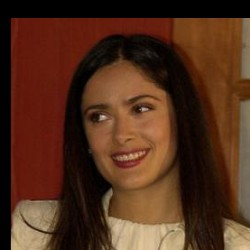

Similarity:  0.676635205745697
Image 4 


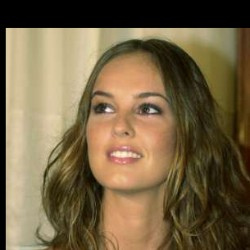

Similarity:  0.6587988138198853
Image 5 


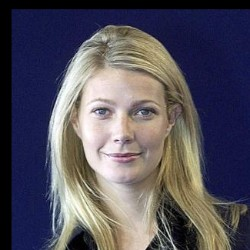

Similarity:  0.6566644906997681
Image 6 


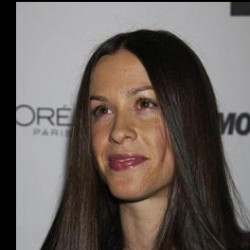

Similarity:  0.6547085046768188
Image 7 


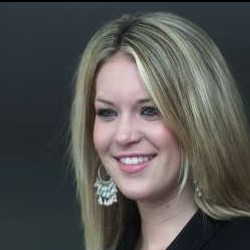

Similarity:  0.6526055335998535
Image 8 


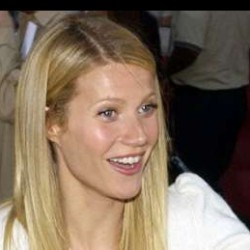

Similarity:  0.6407308578491211
Image 9 


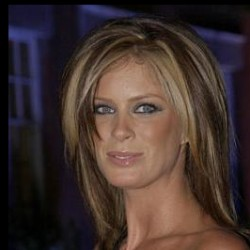

Similarity:  0.6282323598861694
Image 10 


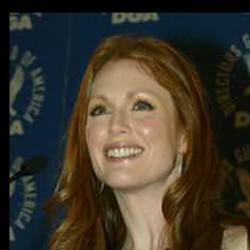

Similarity:  0.6247127652168274
Image 11 


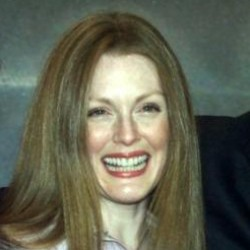

Similarity:  0.6238314509391785
Image 12 


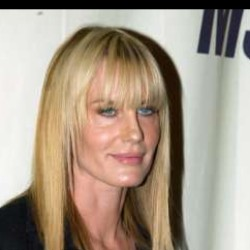

Similarity:  0.6188843846321106
Image 13 


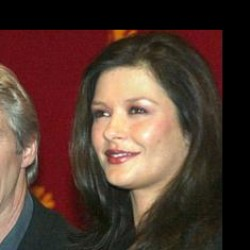

Similarity:  0.6106752753257751
Image 14 


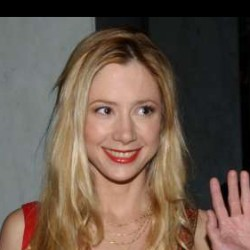

Similarity:  0.6082088947296143
Image 15 


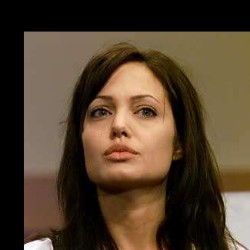

Similarity:  0.6076670289039612
Image 16 


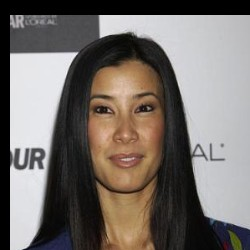

Similarity:  0.6007486581802368
Image 17 


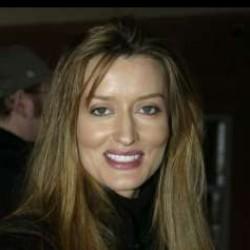

Similarity:  0.5893727540969849
Image 18 


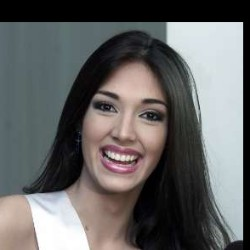

Similarity:  0.5856686234474182
Image 19 


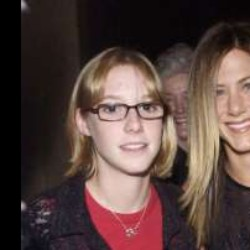

Similarity:  0.5772086381912231
Image 20 


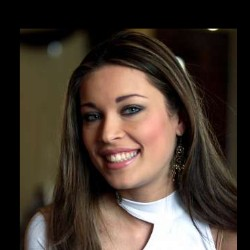

Similarity:  0.576573371887207


In [56]:
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 1")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Query 6

Query Image 6


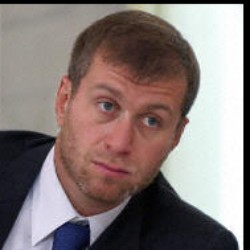



Image 1 


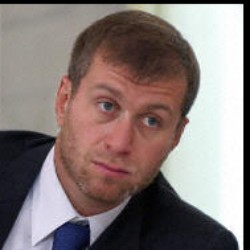

Similarity:  1.0
Image 2 


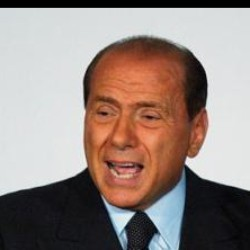

Similarity:  0.7321699857711792
Image 3 


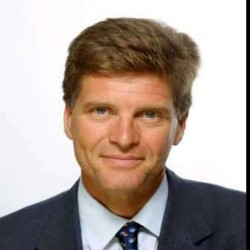

Similarity:  0.6753451824188232
Image 4 


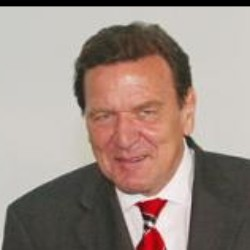

Similarity:  0.6659607887268066
Image 5 


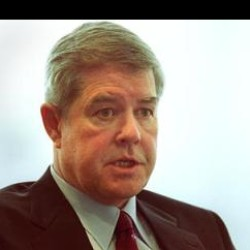

Similarity:  0.6615517735481262
Image 6 


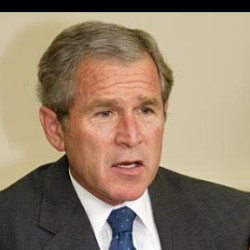

Similarity:  0.6500501036643982
Image 7 


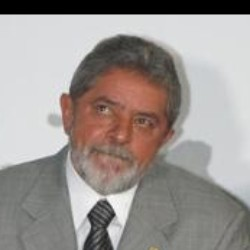

Similarity:  0.6285810470581055
Image 8 


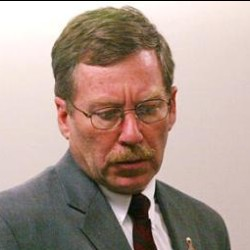

Similarity:  0.6246923208236694
Image 9 


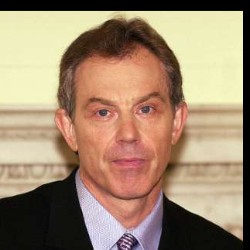

Similarity:  0.6234934329986572
Image 10 


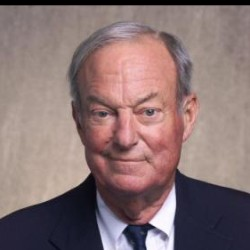

Similarity:  0.6204068064689636
Image 11 


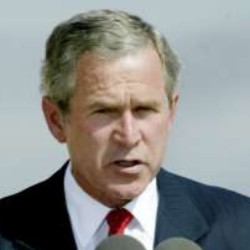

Similarity:  0.6076626777648926
Image 12 


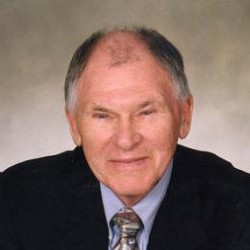

Similarity:  0.6031991839408875
Image 13 


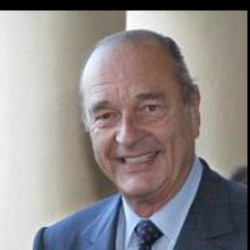

Similarity:  0.602708637714386
Image 14 


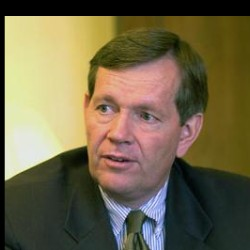

Similarity:  0.6001428365707397
Image 15 


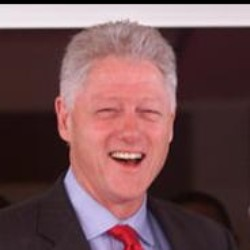

Similarity:  0.5908218622207642
Image 16 


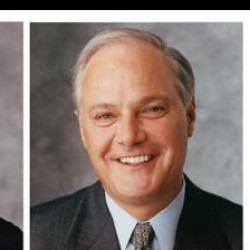

Similarity:  0.5904861688613892
Image 17 


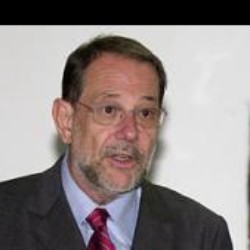

Similarity:  0.5879203677177429
Image 18 


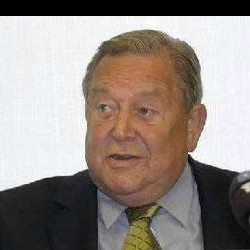

Similarity:  0.5866479277610779
Image 19 


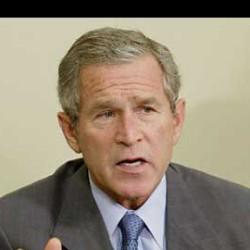

Similarity:  0.5857110023498535
Image 20 


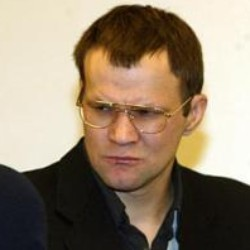

Similarity:  0.5833331942558289


In [57]:
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 6")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Query 7

Query Image 7


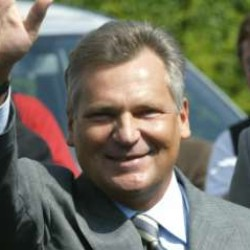



Image 1 


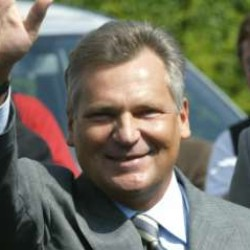

Similarity:  1.0
Image 2 


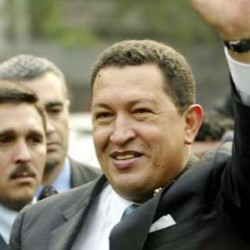

Similarity:  0.5359322428703308
Image 3 


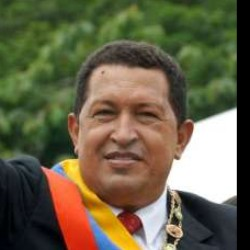

Similarity:  0.5127941370010376
Image 4 


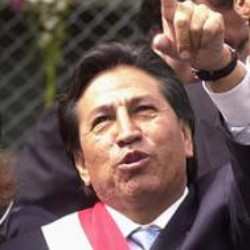

Similarity:  0.49421462416648865
Image 5 


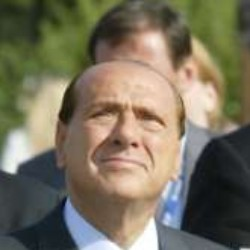

Similarity:  0.4916153848171234
Image 6 


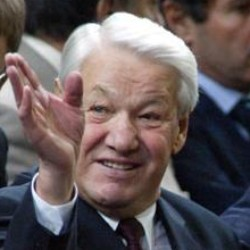

Similarity:  0.4914093017578125
Image 7 


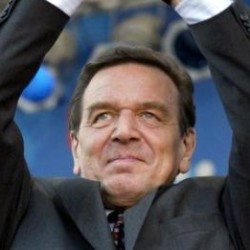

Similarity:  0.47776293754577637
Image 8 


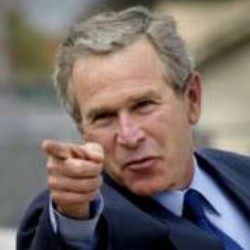

Similarity:  0.4763621985912323
Image 9 


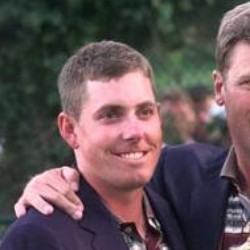

Similarity:  0.4761626422405243
Image 10 


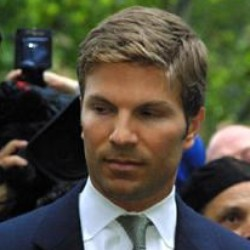

Similarity:  0.47395196557044983
Image 11 


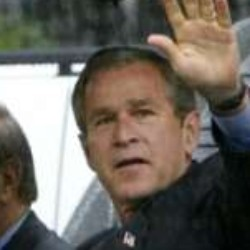

Similarity:  0.4736615717411041
Image 12 


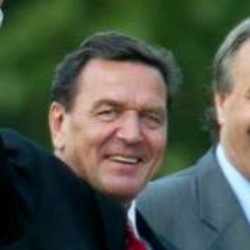

Similarity:  0.4730806350708008
Image 13 


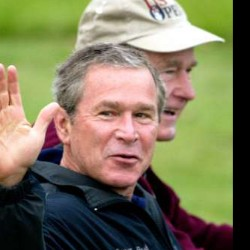

Similarity:  0.4724564850330353
Image 14 


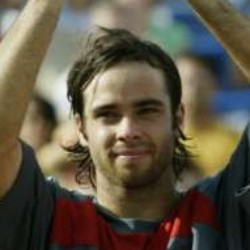

Similarity:  0.4635196030139923
Image 15 


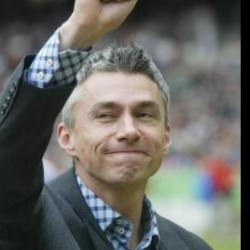

Similarity:  0.4586471915245056
Image 16 


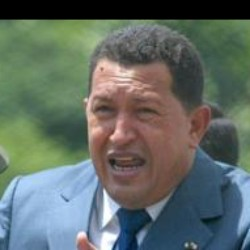

Similarity:  0.45818424224853516
Image 17 


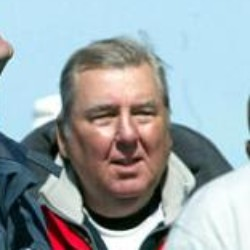

Similarity:  0.45386940240859985
Image 18 


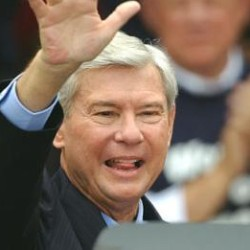

Similarity:  0.4531368911266327
Image 19 


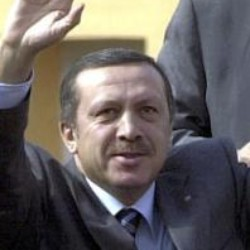

Similarity:  0.4458780288696289
Image 20 


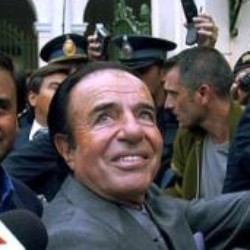

Similarity:  0.44558125734329224


In [62]:
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 7")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Query 8

Query Image 8


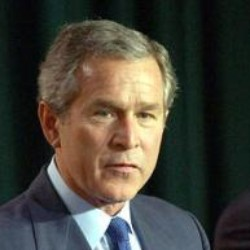



Image 1 


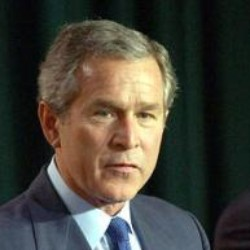

Similarity:  1.0
Image 2 


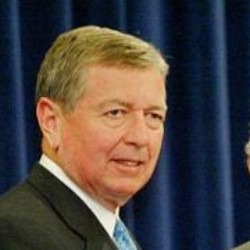

Similarity:  0.674890398979187
Image 3 


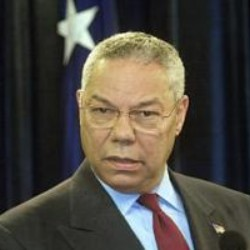

Similarity:  0.6482441425323486
Image 4 


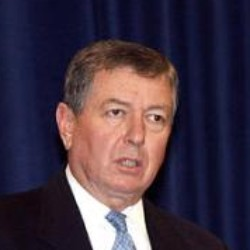

Similarity:  0.6300944089889526
Image 5 


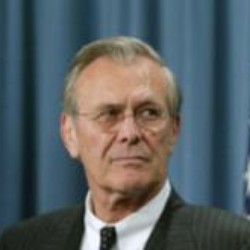

Similarity:  0.626973032951355
Image 6 


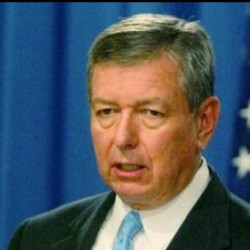

Similarity:  0.6199960112571716
Image 7 


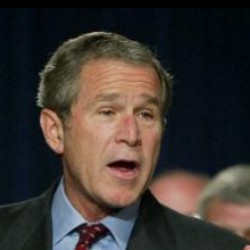

Similarity:  0.6163831949234009
Image 8 


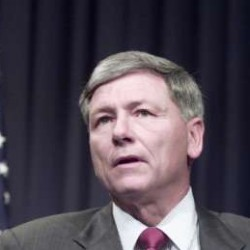

Similarity:  0.6150987148284912
Image 9 


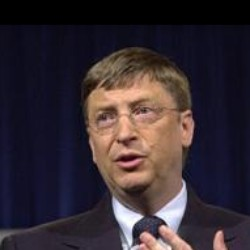

Similarity:  0.6030303835868835
Image 10 


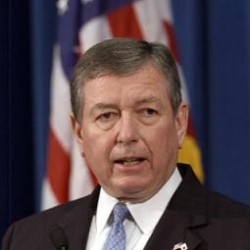

Similarity:  0.6013526320457458
Image 11 


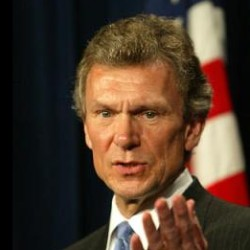

Similarity:  0.593525767326355
Image 12 


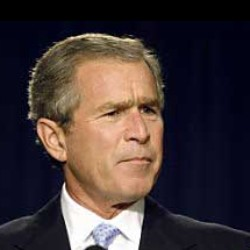

Similarity:  0.592983603477478
Image 13 


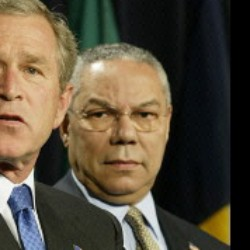

Similarity:  0.5896920561790466
Image 14 


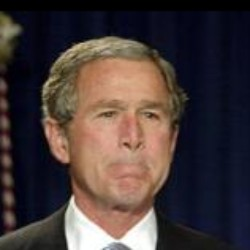

Similarity:  0.5896515846252441
Image 15 


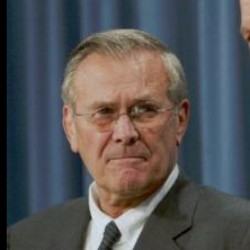

Similarity:  0.587979257106781
Image 16 


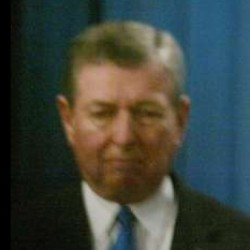

Similarity:  0.5729063153266907
Image 17 


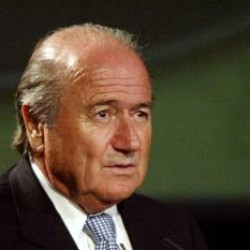

Similarity:  0.570796549320221
Image 18 


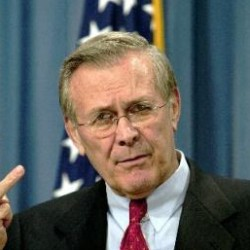

Similarity:  0.568008542060852
Image 19 


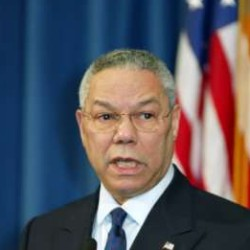

Similarity:  0.5633918642997742
Image 20 


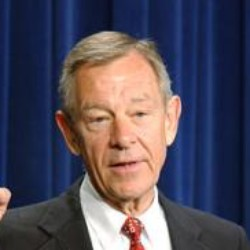

Similarity:  0.5596447587013245


In [61]:
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 8")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Query 9

Query Image 9


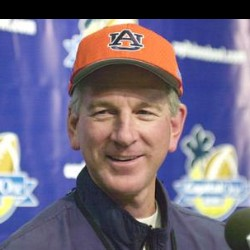



Image 1 


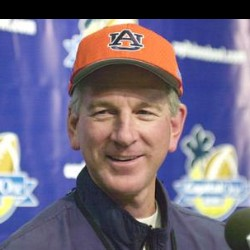

Similarity:  1.0
Image 2 


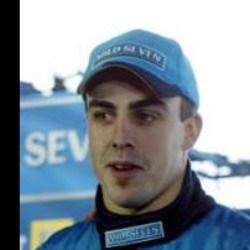

Similarity:  0.652018666267395
Image 3 


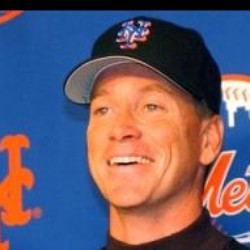

Similarity:  0.6261680126190186
Image 4 


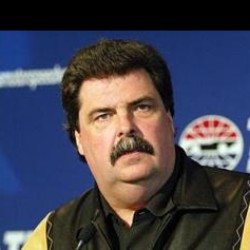

Similarity:  0.6248623132705688
Image 5 


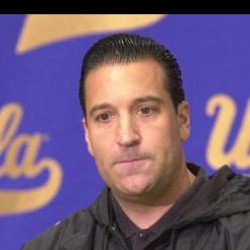

Similarity:  0.6159597635269165
Image 6 


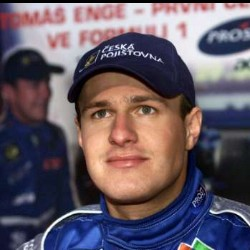

Similarity:  0.6010360717773438
Image 7 


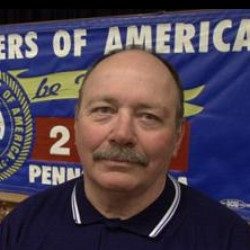

Similarity:  0.5769813060760498
Image 8 


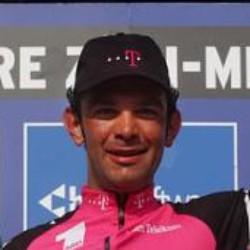

Similarity:  0.5762926936149597
Image 9 


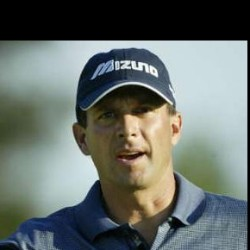

Similarity:  0.574362576007843
Image 10 


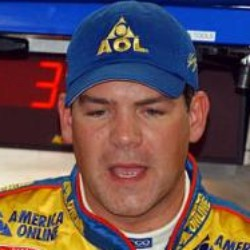

Similarity:  0.5714314579963684
Image 11 


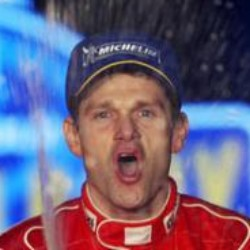

Similarity:  0.5659202933311462
Image 12 


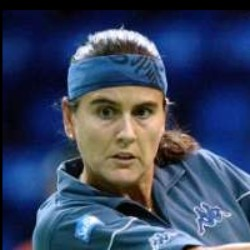

Similarity:  0.5651081204414368
Image 13 


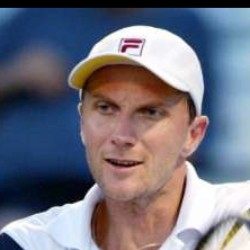

Similarity:  0.5595829486846924
Image 14 


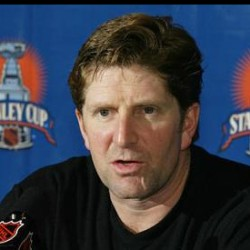

Similarity:  0.5508711338043213
Image 15 


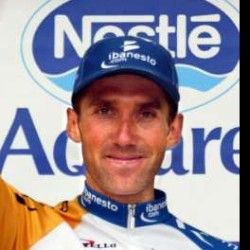

Similarity:  0.5497620105743408
Image 16 


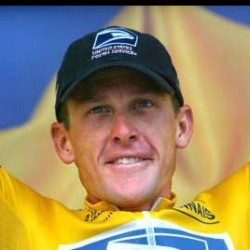

Similarity:  0.5409436821937561
Image 17 


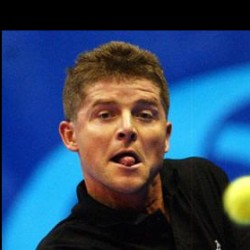

Similarity:  0.5409286022186279
Image 18 


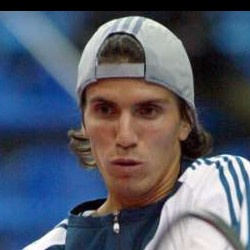

Similarity:  0.5336770415306091
Image 19 


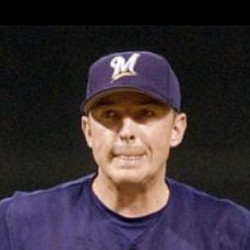

Similarity:  0.5298683643341064
Image 20 


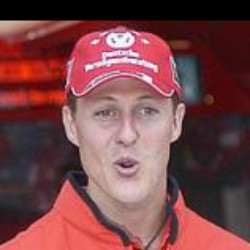

Similarity:  0.5287419557571411


In [60]:
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 9")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])

Query 10

Query Image 10


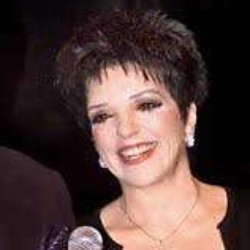



Image 1 


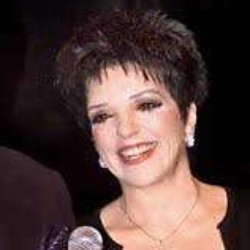

Similarity:  1.0
Image 2 


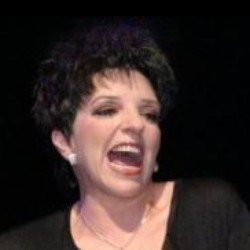

Similarity:  0.6712571382522583
Image 3 


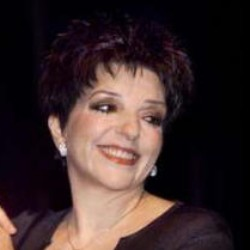

Similarity:  0.658784806728363
Image 4 


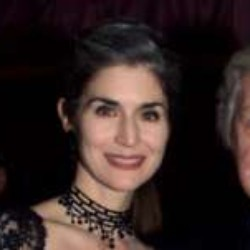

Similarity:  0.6347324848175049
Image 5 


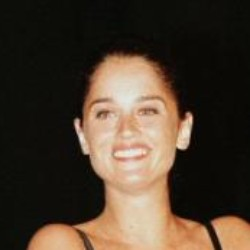

Similarity:  0.6265529990196228
Image 6 


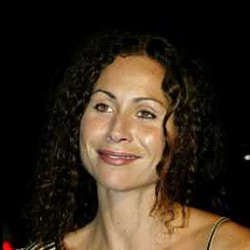

Similarity:  0.6122968792915344
Image 7 


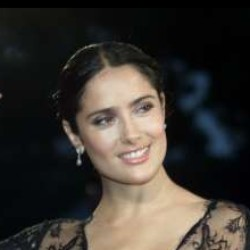

Similarity:  0.58427894115448
Image 8 


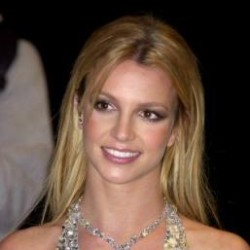

Similarity:  0.5743948817253113
Image 9 


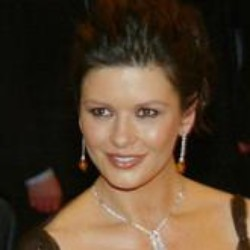

Similarity:  0.5582500696182251
Image 10 


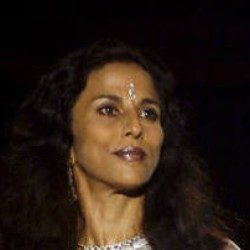

Similarity:  0.5411900877952576
Image 11 


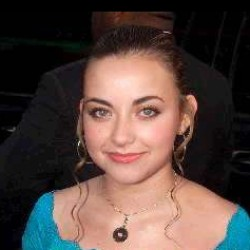

Similarity:  0.5313292145729065
Image 12 


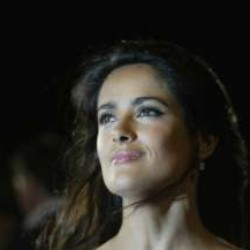

Similarity:  0.5290127992630005
Image 13 


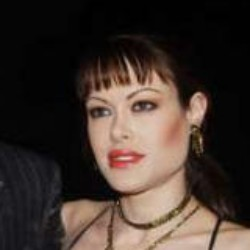

Similarity:  0.5247093439102173
Image 14 


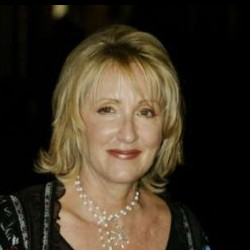

Similarity:  0.5214988589286804
Image 15 


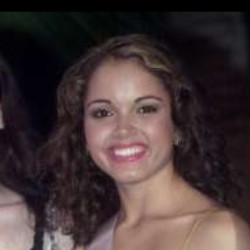

Similarity:  0.520280659198761
Image 16 


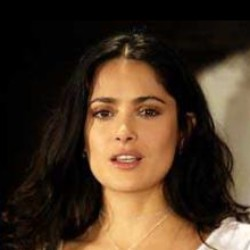

Similarity:  0.5146470665931702
Image 17 


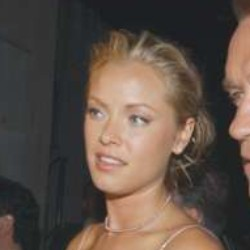

Similarity:  0.5107415914535522
Image 18 


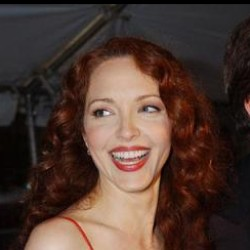

Similarity:  0.508338451385498
Image 19 


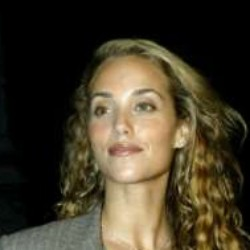

Similarity:  0.5040026903152466
Image 20 


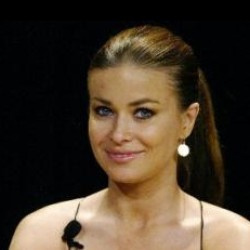

Similarity:  0.5031128525733948


In [64]:
q_idx,thumbs,idx_closest,test_similar=ret(image_paths)
print("Query Image 10")
display(Image(filename=image_paths[q_idx]))
print("\n")
for i,idx in enumerate(idx_closest):  
    print("Image %d "%(i+1))
    display(Image(filename=image_paths[idx]))  
    print("Similarity: ",1-test_similar[i])